<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/education_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 教育スコア
- input
    - public_school_score.csv
        - 小学校スコア
        - 中学校スコア
    - library_score.csv
        - 図書館スコア
- output
    - education_score.csv
        - 教育スコア


In [1]:
!pip install -q japanize-matplotlib

     |████████████████████████████████| 4.1 MB 33.5 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
score_name = '教育スコア'
output_score_file = 'education_score.csv'

### 人口マスタ

In [16]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[[
    '地域ID', '市区町村名', '町名', '町丁目'
]].set_index('地域ID')
print(df_pop_master.shape)

(3145, 3)


### 学校スコア

In [17]:
df_school_score = pd.read_csv(os.path.join(DIR_NAME, 'public_school_score.csv'))[[
    '地域ID',
    '_小学校スコア', '小学校スコア',
    '_中学校スコア', '中学校スコア',
]].set_index('地域ID')
print(df_school_score.shape)

(3145, 4)


In [18]:
df_school_score.head()

,_小学校スコア,小学校スコア,_中学校スコア,中学校スコア
地域ID,,,,
101003,0.758635,2.937123,0.201413,0.076566
101004,0.665746,1.763243,0.201413,0.076566
101005,0.648765,1.556525,0.350953,0.286854
101007,0.660258,1.693798,0.486260,0.992128
101008,0.811935,3.761628,0.313534,0.209210


### 図書館

In [19]:
df_library_score = pd.read_csv(os.path.join(DIR_NAME, 'library_score.csv'))[[
    '地域ID', '_図書館スコア', '図書館スコア'
]].set_index('地域ID')
print(df_library_score.shape)

(3145, 2)


In [20]:
df_library_score.head()

,_図書館スコア,図書館スコア
地域ID,,
101003,0.446415,0.812905
101004,0.449642,0.827762
101005,0.504223,1.233763
101007,0.622203,2.373183
101008,0.611363,2.270243


In [28]:
def normalize_score(sr_data, high=True, outlier=True):
    score = (sr_data - sr_data.mean())/sr_data.std()
    score = score if high else -score

    if outlier:
        high_s = score.quantile(0.99)
        low_s = score.quantile(0.01)
        score[score > high_s] = high_s
        score[score < low_s] = low_s
    else:
        high_s = score.max()
        low_s = score.min()
        
    return (score - low_s)/(high_s - low_s)


def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

### 教育スコア

In [21]:
df_score = pd.concat([
    df_pop_master,
    df_school_score,
    df_library_score
], axis=1)
print(df_score.shape)
assert len(df_score) == len(df_pop_master)

(3145, 9)


In [22]:
print(df_score.shape)
df_score.head()

(3145, 9)


,市区町村名,町名,町丁目,_小学校スコア,小学校スコア,_中学校スコア,中学校スコア,_図書館スコア,図書館スコア
地域ID,,,,,,,,,
101003,千代田区,丸の内,丸の内１丁目,0.758635,2.937123,0.201413,0.076566,0.446415,0.812905
101004,千代田区,丸の内,丸の内２丁目,0.665746,1.763243,0.201413,0.076566,0.449642,0.827762
101005,千代田区,丸の内,丸の内３丁目,0.648765,1.556525,0.350953,0.286854,0.504223,1.233763
101007,千代田区,大手町,大手町１丁目,0.660258,1.693798,0.486260,0.992128,0.622203,2.373183
101008,千代田区,大手町,大手町２丁目,0.811935,3.761628,0.313534,0.209210,0.611363,2.270243


In [23]:
feature_list = {
    '_小学校スコア': {'high': True, 'outlier': False, 'weight': 1}, 
    '_中学校スコア': {'high': True, 'outlier': False, 'weight': 1}, 
    '_図書館スコア': {'high': True, 'outlier': False, 'weight': 1},
}

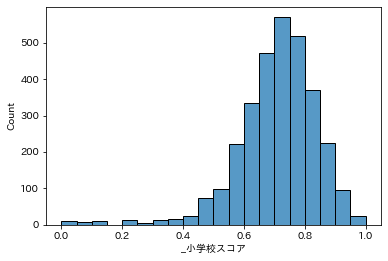

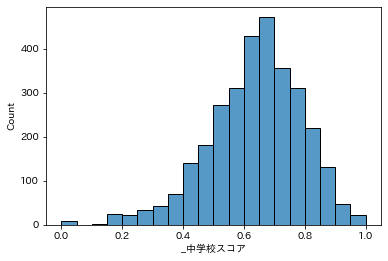

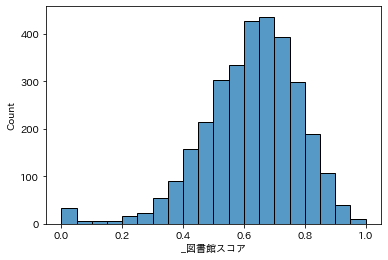

In [25]:
for feature_name in feature_list.keys():
    sns.histplot(df_score[feature_name], bins=20)
    plt.show()

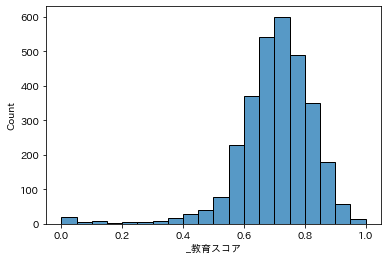

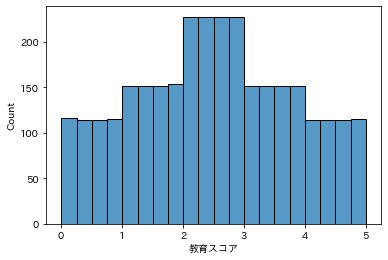

In [32]:
score_list = []
for key, value in feature_list.items():
    score_list.append(df_score[key] * value['weight'])

score_sub_name = '_' + score_name
df_score[score_sub_name] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False), outlier=False)
df_score[score_name] = rank_score(df_score[score_sub_name])

score_list = [score_sub_name, score_name]
for _score in score_list:
    sns.histplot(df_score[_score], bins=20)
    plt.show()

In [34]:
df_score[
    ['市区町村名', '町丁目'] + list(feature_list.keys()) + score_list
].to_csv(os.path.join(DIR_NAME, output_score_file), index=True)

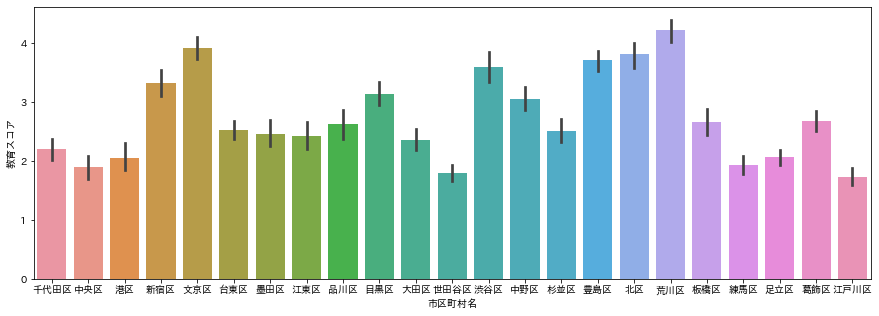

In [35]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_score)
plt.show()

In [36]:
df_level = df_score.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目'] + score_list + list(feature_list.keys())
].reset_index(drop=True)
print(df_level.shape)

(891, 8)


In [37]:
df_level.head(20)

,市区町村名,町名,町丁目,_教育スコア,教育スコア,_小学校スコア,_中学校スコア,_図書館スコア
0,北区,田端,田端５丁目,1.000000,5.000000,0.950640,0.882302,0.899413
1,新宿区,北山伏町,北山伏町,0.999017,4.997811,0.964394,0.997644,0.767775
2,新宿区,市谷山伏町,市谷山伏町,0.997606,4.995623,1.000000,0.949608,0.776559
3,新宿区,早稲田南町,早稲田南町,0.988646,4.991245,0.909099,0.962309,0.831604
4,北区,上十条,上十条３丁目,0.983122,4.986868,0.841526,0.859278,0.987929
5,文京区,千石,千石２丁目,0.977164,4.984679,0.925070,0.912243,0.836025
6,新宿区,早稲田鶴巻町,早稲田鶴巻町,0.976932,4.982491,0.922721,0.797851,0.952166
7,新宿区,喜久井町,喜久井町,0.969592,4.980302,0.878364,0.957142,0.818262
8,新宿区,新宿,新宿６丁目,0.969194,4.978113,0.983096,0.915194,0.754450
9,新宿区,市谷甲良町,市谷甲良町,0.963388,4.973736,0.969294,0.928861,0.739581


In [38]:
df_level.tail(20)

,市区町村名,町名,町丁目,_教育スコア,教育スコア,_小学校スコア,_中学校スコア,_図書館スコア
871,大田区,昭和島,昭和島１丁目,0.510119,0.326111,0.555781,0.403182,0.507361
872,江東区,有明,有明１丁目,0.507675,0.319545,0.613801,0.573723,0.272484
873,江戸川区,興宮町,興宮町,0.503172,0.308601,0.464542,0.574904,0.408925
874,千代田区,永田町,永田町２丁目,0.502163,0.302035,0.343135,0.688687,0.413941
875,中央区,豊海町,豊海町,0.493075,0.284526,0.851264,0.294823,0.276190
876,葛飾区,水元公園,水元公園,0.487909,0.271394,0.563686,0.446299,0.398940
877,品川区,八潮,八潮１丁目,0.470151,0.240753,0.523156,0.499801,0.340076
878,世田谷区,砧公園,砧公園,0.455754,0.223244,0.361664,0.498929,0.465233
879,港区,海岸,海岸１丁目,0.451757,0.218866,0.489327,0.402260,0.423907
880,千代田区,千代田,千代田,0.449539,0.210112,0.336956,0.447310,0.525497
